## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

# 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

In [1]:
import os
from tensorflow.python import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.python.keras.layers import BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(
                units=n_units,
                activation="relu",
                name="hidden_layer" + str(i + 1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(
                units=n_units,
                activation="relu",
                name="hidden_layer" + str(i + 1))(x)
            x = BatchNormalization()(x)

    out = keras.layers.Dense(
        units=output_units, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

results = {}

for i in range(2):
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(
        lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(
        loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

    if i == 1:
        reduce_lr = ReduceLROnPlateau(
            factor=0.5,
            min_lr=1e-12,
            monitor='val_loss',
            patience=5,
            verbose=1)
    else:
        reduce_lr = ReduceLROnPlateau(
            factor=0.8,
            min_lr=1e-12,
            monitor='val_loss',
            patience=8,
            verbose=1)

    model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        shuffle=True,
        callbacks=[reduce_lr])

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    name_tag = "f=0.5 p=5" if i == 0 else "f=0.8 p=8"
    results[name_tag] = {
        'train-loss': train_loss,
        'valid-loss': valid_loss,
        'train-acc': train_acc,
        'valid-acc': valid_acc
    }

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 128)               512   

Epoch 47/50
50000/50000 [==============================] - 1s 23us/sample - loss: 0.6076 - acc: 0.8184 - val_loss: 1.5976 - val_acc: 0.4950
Epoch 48/50
50000/50000 [==============================] - 1s 24us/sample - loss: 0.5969 - acc: 0.8235 - val_loss: 1.5986 - val_acc: 0.4943
Epoch 49/50
50000/50000 [==============================] - 1s 23us/sample - loss: 0.5884 - acc: 0.8252 - val_loss: 1.6024 - val_acc: 0.4950
Epoch 50/50
50000/50000 [==============================] - 1s 24us/sample - loss: 0.5773 - acc: 0.8303 - val_loss: 1.6132 - val_acc: 0.4901
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v1 (Batc 

Epoch 41/50
50000/50000 [==============================] - 1s 24us/sample - loss: 0.8030 - acc: 0.7410 - val_loss: 1.4708 - val_acc: 0.4964
Epoch 42/50
50000/50000 [==============================] - 1s 23us/sample - loss: 0.8009 - acc: 0.7418 - val_loss: 1.4718 - val_acc: 0.4962
Epoch 43/50
50000/50000 [==============================] - 1s 24us/sample - loss: 0.7984 - acc: 0.7425 - val_loss: 1.4728 - val_acc: 0.4964
Epoch 44/50
50000/50000 [==============================] - 1s 24us/sample - loss: 0.7974 - acc: 0.7427 - val_loss: 1.4748 - val_acc: 0.4973
Epoch 45/50
47104/50000 [===========================>..] - ETA: 0s - loss: 0.7967 - acc: 0.7432
Epoch 00045: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
50000/50000 [==============================] - 1s 24us/sample - loss: 0.7965 - acc: 0.7432 - val_loss: 1.4735 - val_acc: 0.4959
Epoch 46/50
50000/50000 [==============================] - 1s 23us/sample - loss: 0.7937 - acc: 0.7445 - val_loss: 1.4735 - val_acc: 0.4

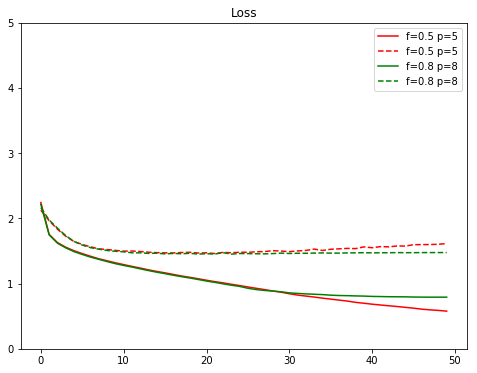

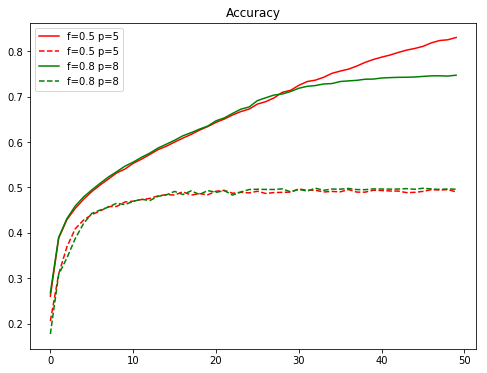

In [8]:
# 繪製結果
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-loss'])),
        results[cond]['train-loss'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-loss'])),
        results[cond]['valid-loss'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-acc'])),
        results[cond]['train-acc'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-acc'])),
        results[cond]['valid-acc'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [9]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

results = {}

for i in range(2):
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(
        lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)

    if i == 1:
        optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    else:
        optimizer = keras.optimizers.RMSprop(lr=LEARNING_RATE)

    model.compile(
        loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

    reduce_lr = ReduceLROnPlateau(
        factor=0.5, min_lr=1e-12, monitor='val_loss', patience=5, verbose=1)

    model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        shuffle=True,
        callbacks=[reduce_lr])

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    name_tag = "Adam" if i == 0 else "RMSprop"
    results[name_tag] = {
        'train-loss': train_loss,
        'valid-loss': valid_loss,
        'train-acc': train_acc,
        'valid-acc': valid_acc
    }

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 128)               512   

50000/50000 [==============================] - 1s 25us/sample - loss: 0.3029 - acc: 0.9263 - val_loss: 1.7174 - val_acc: 0.5354
Epoch 44/50
50000/50000 [==============================] - 1s 25us/sample - loss: 0.3011 - acc: 0.9266 - val_loss: 1.7301 - val_acc: 0.5357
Epoch 45/50
47104/50000 [===========================>..] - ETA: 0s - loss: 0.2990 - acc: 0.9277
Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
50000/50000 [==============================] - 1s 25us/sample - loss: 0.2990 - acc: 0.9278 - val_loss: 1.7343 - val_acc: 0.5362
Epoch 46/50
50000/50000 [==============================] - 1s 25us/sample - loss: 0.2931 - acc: 0.9305 - val_loss: 1.7334 - val_acc: 0.5331
Epoch 47/50
50000/50000 [==============================] - 1s 26us/sample - loss: 0.2925 - acc: 0.9306 - val_loss: 1.7337 - val_acc: 0.5355
Epoch 48/50
50000/50000 [==============================] - 1s 25us/sample - loss: 0.2909 - acc: 0.9307 - val_loss: 1.7402 - val_acc: 0.5344
Epoch 4

50000/50000 [==============================] - 1s 25us/sample - loss: 0.3379 - acc: 0.9178 - val_loss: 1.5929 - val_acc: 0.5284
Epoch 34/50
50000/50000 [==============================] - 1s 26us/sample - loss: 0.3332 - acc: 0.9192 - val_loss: 1.6000 - val_acc: 0.5289
Epoch 35/50
50000/50000 [==============================] - 1s 26us/sample - loss: 0.3302 - acc: 0.9212 - val_loss: 1.6095 - val_acc: 0.5289
Epoch 36/50
50000/50000 [==============================] - 1s 25us/sample - loss: 0.3269 - acc: 0.9214 - val_loss: 1.6107 - val_acc: 0.5275
Epoch 37/50
48128/50000 [===========================>..] - ETA: 0s - loss: 0.3242 - acc: 0.9238
Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
50000/50000 [==============================] - 1s 26us/sample - loss: 0.3244 - acc: 0.9237 - val_loss: 1.6266 - val_acc: 0.5294
Epoch 38/50
50000/50000 [==============================] - 1s 26us/sample - loss: 0.3177 - acc: 0.9261 - val_loss: 1.6157 - val_acc: 0.5301
Epoch 3

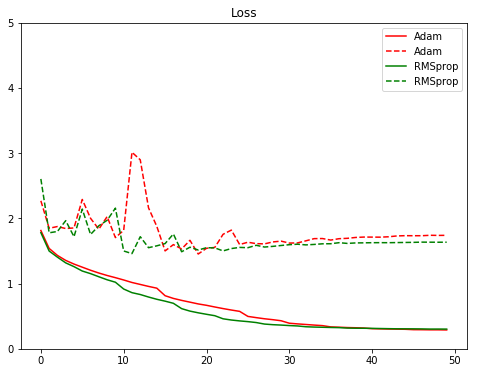

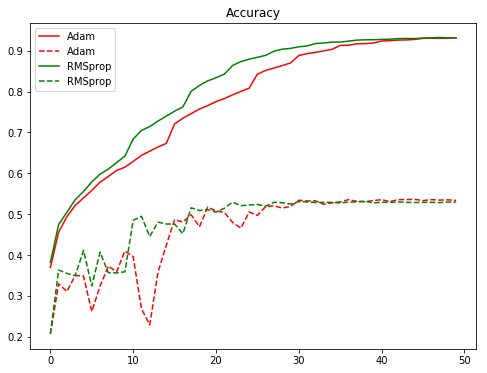

In [10]:
# 繪製結果
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-loss'])),
        results[cond]['train-loss'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-loss'])),
        results[cond]['valid-loss'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-acc'])),
        results[cond]['train-acc'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-acc'])),
        results[cond]['valid-acc'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()